## Read data

In [2]:
import numpy as np
import pandas as pd
import datetime
import os
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import pickle
from collections import OrderedDict
import copy
from scipy.sparse import csr_matrix
from scipy import io
import seaborn as sns
import joblib
from base import *
from joblib import Parallel, delayed
import random
import scipy as sc
import sys

In [3]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

### Read raw speed and count data

In [4]:
# start_month=int(sys.argv[1])
# start_day=int(sys.argv[2])
# end_month=int(sys.argv[3])
# end_day=int(sys.argv[4])
# year =int(sys.argv[5])
# flag_weekday = int(sys.argv[6])

#2020-06-26 - 2020-07-06

start_month=3
start_day=20
end_month=3
end_day=20
year =2020
flag_weekday = 1

In [6]:
read_in_folder = './Processed_data/20200320/'
write_folder = './Numerical_result/06_22_2022_NumericalResult/'
# read_in_folder = './network_decompose/small_network/network_testcases/network_sm/'
# os.chdir('./network_testcases/network_sm/')

with open(read_in_folder+'volume_dict_link_4.pkl', 'rb') as handle:
    count_data = pickle.load(handle)
with open(read_in_folder+'speed_dict_link_4.pkl', 'rb') as handle:
    spd_data = pickle.load(handle)
    
print(spd_data)

{0: time        00:00:00  00:05:00  00:10:00  00:15:00  00:20:00  00:25:00  \
date                                                                     
2020-03-20      64.9      64.1      64.1      64.2      64.8      63.9   

time        00:30:00  00:35:00  00:40:00  00:45:00  ...  23:10:00  23:15:00  \
date                                                ...                       
2020-03-20      63.5      63.7      63.8      63.4  ...      66.1      65.3   

time        23:20:00  23:25:00  23:30:00  23:35:00  23:40:00  23:45:00  \
date                                                                     
2020-03-20      65.9      66.3      65.4      64.8      65.0      65.6   

time        23:50:00  23:55:00  
date                            
2020-03-20      65.4      64.3  

[1 rows x 288 columns], 1: time        00:00:00  00:05:00  00:10:00  00:15:00  00:20:00  00:25:00  \
date                                                                     
2020-03-20      63.4      63.6      6

### Read graph data

In [7]:
with open(read_in_folder+'od_list.pickle', 'rb') as handle:
    (O_list, D_list) = pickle.load(handle)
# with open('graph.pickle', 'rb') as handle:
#     G = pickle.load(handle)
G = nx.read_gpickle(read_in_folder+'graph_4.pickle')

# with open(read_in_folder+'od_list_4.pickle', 'rb') as handle:
#     pickle.dump((O_list, D_list),handle, protocol=4)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]


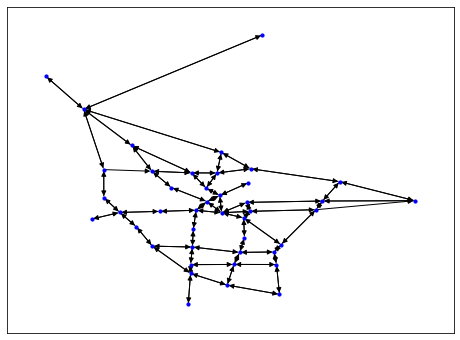

In [8]:
with open(read_in_folder+'od_list.pickle', 'rb') as handle:
    (O_list, D_list) = pickle.load(handle)
# with open('graph.pickle', 'rb') as handle:
#     G = pickle.load(handle)
G = nx.read_gpickle(read_in_folder+'graph_4.pickle')
G = nx.freeze(G)
# print(O_list)
pos=nx.get_node_attributes(G,'pos')
plt.rcParams['figure.figsize'] = [8, 6]
nx.draw_networkx(G,pos,node_size=10,node_color='blue',with_labels=False)
# print(G.number_of_edges())
# print(G.number_of_nodes())
Node = list(G.nodes)
Node.sort()
# print("Nodes: ", Node)

print(O_list)


## Interpolate the data

for name in count_data.keys():
    count_data[name] = count_data[name].replace(0.0, np.nan)
    count_data[name] = count_data[name].interpolate(method='linear', axis=0)
    count_data[name] = count_data[name].interpolate(method='linear', axis=1)
    count_data[name] = count_data[name].fillna(value = count_data[name].mean().mean())
    print(name,", ",count_data[name])
for name in spd_data.keys():
    spd_data[name] = spd_data[name].replace(0.0, np.nan)
    spd_data[name] = spd_data[name].interpolate(method='linear', axis=0)
    spd_data[name] = spd_data[name].interpolate(method='linear', axis=1)
    spd_data[name] = spd_data[name].fillna(value = spd_data[name].mean().mean())

## Set Parameters

In [9]:
#no > flag_weekday1 & no < flag_weekday2:
if flag_weekday == 1:
    flag_weekday1 = -1
    flag_weekday2 = 5
else:
    flag_weekday1 = 4
    flag_weekday2 = 7

start_date = datetime.date(year, start_month, start_day)
end_date = datetime.date(year, end_month, end_day)
delta_date = datetime.timedelta(days = 1)
time_basis = datetime.time(0,0,0)
N_path = 1
time_interval_min = 6*60

## Enuerate all paths
todo: 
1. based on the network, select k shortest path
algorithm:
1. find all path
2. order the path by length
3. take the first k shortest path

In [13]:
from itertools import islice
def k_shortest_paths(G, source, target, k, weight=None):
    def path_cost(G, path):
        return sum([G[path[i]][path[i+1]]['length'] for i in range(len(path)-1)])
    p = list(islice(nx.shortest_simple_paths(G, source, target, weight=weight), k))
    #print('p',p)
#     if(len(p) < k) or (len(p[k-1]) <= 0):
#         return (float('inf'), [])
#     else:
#         return [path_cost(G,p[k-1]), p[k-1]]
    return p

#print(k_shortest_paths(G,737184,718421,1,weight='length'))

In [14]:
OD_paths = OrderedDict()
link_dict = OrderedDict()
path_list = list()
# O_list = O_list[:]
# D_list = D_list[:]
shortest_path_list = list()
count = 0;
k=1
N_path = 1
# while len(shortest_path_list) < N_path:
OD_list_output = []
print(O_list)
for O in O_list:
    for D in O_list:
        print(O, D);
        if O!=D:
            try:
                paths = k_shortest_paths(G,O, D,N_path,weight='length') #My code
                if len(paths) != 0:
                    tmp_path_list = list()
                    for path in paths:
                        path_o = Path()
                        path_o.node_list = path
                        path_o.node_to_list(G, link_dict)
                        tmp_path_list.append(path_o)
                        path_list.append(path_o)
                        
                    OD_paths[(O, D)] = tmp_path_list
                    shortest_path_list.append(paths)
                    OD_list_output.append([O,D])
                    print("From ", O, " To ", D, "there are ", k, "paths")
                else:
                    pass
            except:
#                     print("From ", O, " To ", D, "there are no paths")
                pass
        else:
#                 print("From ", O, " To ", D, "same")
            pass
np.savetxt('path_'+start_date.strftime("%m_%d_%Y")+'_'+\
           str(time_interval_min)+'.txt', OD_list_output, delimiter = ',',fmt='%s')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
0 0
0 1
From  0  To  1 there are  1 paths
0 2
From  0  To  2 there are  1 paths
0 3
From  0  To  3 there are  1 paths
0 4
From  0  To  4 there are  1 paths
0 5
From  0  To  5 there are  1 paths
0 6
From  0  To  6 there are  1 paths
0 7
From  0  To  7 there are  1 paths
0 8
From  0  To  8 there are  1 paths
0 9
From  0  To  9 there are  1 paths
0 10
From  0  To  10 there are  1 paths
0 11
From  0  To  11 there are  1 paths
0 12
From  0  To  12 there are  1 paths
0 13
From  0  To  13 there are  1 paths
0 14
From  0  To  14 there are  1 paths
0 15
From  0  To  15 there are  1 paths
0 16
From  0  To  16 there are  1 paths
0 17
From  0  To  17 there are  1 paths
0 18
From  0  To  18 there are  1 paths
0 19
From  0  To  19 there are  1 paths
0 20
From  0  To  20 there are  1 paths
0 21
From  0  To  21 there are  1 paths
0 22
From  

From  6  To  12 there are  1 paths
6 13
From  6  To  13 there are  1 paths
6 14
From  6  To  14 there are  1 paths
6 15
From  6  To  15 there are  1 paths
6 16
From  6  To  16 there are  1 paths
6 17
From  6  To  17 there are  1 paths
6 18
From  6  To  18 there are  1 paths
6 19
From  6  To  19 there are  1 paths
6 20
From  6  To  20 there are  1 paths
6 21
From  6  To  21 there are  1 paths
6 22
From  6  To  22 there are  1 paths
6 23
From  6  To  23 there are  1 paths
6 24
From  6  To  24 there are  1 paths
6 25
From  6  To  25 there are  1 paths
6 26
From  6  To  26 there are  1 paths
6 27
From  6  To  27 there are  1 paths
6 28
From  6  To  28 there are  1 paths
6 29
From  6  To  29 there are  1 paths
6 30
From  6  To  30 there are  1 paths
6 31
From  6  To  31 there are  1 paths
6 32
From  6  To  32 there are  1 paths
6 33
From  6  To  33 there are  1 paths
6 34
From  6  To  34 there are  1 paths
6 35
From  6  To  35 there are  1 paths
6 36
From  6  To  36 there are  1 paths
6 37


From  11  To  30 there are  1 paths
11 31
From  11  To  31 there are  1 paths
11 32
From  11  To  32 there are  1 paths
11 33
From  11  To  33 there are  1 paths
11 34
From  11  To  34 there are  1 paths
11 35
From  11  To  35 there are  1 paths
11 36
From  11  To  36 there are  1 paths
11 37
From  11  To  37 there are  1 paths
11 38
From  11  To  38 there are  1 paths
11 39
From  11  To  39 there are  1 paths
11 40
From  11  To  40 there are  1 paths
11 41
From  11  To  41 there are  1 paths
11 42
From  11  To  42 there are  1 paths
12 0
From  12  To  0 there are  1 paths
12 1
From  12  To  1 there are  1 paths
12 2
From  12  To  2 there are  1 paths
12 3
From  12  To  3 there are  1 paths
12 4
From  12  To  4 there are  1 paths
12 5
From  12  To  5 there are  1 paths
12 6
From  12  To  6 there are  1 paths
12 7
From  12  To  7 there are  1 paths
12 8
From  12  To  8 there are  1 paths
12 9
From  12  To  9 there are  1 paths
12 10
From  12  To  10 there are  1 paths
12 11
From  12  To

From  18  To  4 there are  1 paths
18 5
From  18  To  5 there are  1 paths
18 6
From  18  To  6 there are  1 paths
18 7
From  18  To  7 there are  1 paths
18 8
From  18  To  8 there are  1 paths
18 9
From  18  To  9 there are  1 paths
18 10
From  18  To  10 there are  1 paths
18 11
From  18  To  11 there are  1 paths
18 12
From  18  To  12 there are  1 paths
18 13
From  18  To  13 there are  1 paths
18 14
From  18  To  14 there are  1 paths
18 15
From  18  To  15 there are  1 paths
18 16
From  18  To  16 there are  1 paths
18 17
From  18  To  17 there are  1 paths
18 18
18 19
From  18  To  19 there are  1 paths
18 20
From  18  To  20 there are  1 paths
18 21
From  18  To  21 there are  1 paths
18 22
From  18  To  22 there are  1 paths
18 23
From  18  To  23 there are  1 paths
18 24
From  18  To  24 there are  1 paths
18 25
From  18  To  25 there are  1 paths
18 26
From  18  To  26 there are  1 paths
18 27
From  18  To  27 there are  1 paths
18 28
From  18  To  28 there are  1 paths
18 

From  24  To  29 there are  1 paths
24 30
From  24  To  30 there are  1 paths
24 31
From  24  To  31 there are  1 paths
24 32
From  24  To  32 there are  1 paths
24 33
From  24  To  33 there are  1 paths
24 34
From  24  To  34 there are  1 paths
24 35
From  24  To  35 there are  1 paths
24 36
From  24  To  36 there are  1 paths
24 37
From  24  To  37 there are  1 paths
24 38
From  24  To  38 there are  1 paths
24 39
From  24  To  39 there are  1 paths
24 40
From  24  To  40 there are  1 paths
24 41
From  24  To  41 there are  1 paths
24 42
From  24  To  42 there are  1 paths
25 0
From  25  To  0 there are  1 paths
25 1
From  25  To  1 there are  1 paths
25 2
From  25  To  2 there are  1 paths
25 3
From  25  To  3 there are  1 paths
25 4
From  25  To  4 there are  1 paths
25 5
From  25  To  5 there are  1 paths
25 6
From  25  To  6 there are  1 paths
25 7
From  25  To  7 there are  1 paths
25 8
From  25  To  8 there are  1 paths
25 9
From  25  To  9 there are  1 paths
25 10
From  25  To

From  31  To  11 there are  1 paths
31 12
From  31  To  12 there are  1 paths
31 13
From  31  To  13 there are  1 paths
31 14
From  31  To  14 there are  1 paths
31 15
From  31  To  15 there are  1 paths
31 16
From  31  To  16 there are  1 paths
31 17
From  31  To  17 there are  1 paths
31 18
From  31  To  18 there are  1 paths
31 19
From  31  To  19 there are  1 paths
31 20
From  31  To  20 there are  1 paths
31 21
From  31  To  21 there are  1 paths
31 22
From  31  To  22 there are  1 paths
31 23
From  31  To  23 there are  1 paths
31 24
From  31  To  24 there are  1 paths
31 25
From  31  To  25 there are  1 paths
31 26
From  31  To  26 there are  1 paths
31 27
From  31  To  27 there are  1 paths
31 28
From  31  To  28 there are  1 paths
31 29
From  31  To  29 there are  1 paths
31 30
From  31  To  30 there are  1 paths
31 31
31 32
From  31  To  32 there are  1 paths
31 33
From  31  To  33 there are  1 paths
31 34
From  31  To  34 there are  1 paths
31 35
From  31  To  35 there are  

From  37  To  35 there are  1 paths
37 36
From  37  To  36 there are  1 paths
37 37
37 38
From  37  To  38 there are  1 paths
37 39
From  37  To  39 there are  1 paths
37 40
From  37  To  40 there are  1 paths
37 41
From  37  To  41 there are  1 paths
37 42
From  37  To  42 there are  1 paths
38 0
From  38  To  0 there are  1 paths
38 1
From  38  To  1 there are  1 paths
38 2
From  38  To  2 there are  1 paths
38 3
From  38  To  3 there are  1 paths
38 4
From  38  To  4 there are  1 paths
38 5
From  38  To  5 there are  1 paths
38 6
From  38  To  6 there are  1 paths
38 7
From  38  To  7 there are  1 paths
38 8
From  38  To  8 there are  1 paths
38 9
From  38  To  9 there are  1 paths
38 10
From  38  To  10 there are  1 paths
38 11
From  38  To  11 there are  1 paths
38 12
From  38  To  12 there are  1 paths
38 13
From  38  To  13 there are  1 paths
38 14
From  38  To  14 there are  1 paths
38 15
From  38  To  15 there are  1 paths
38 16
From  38  To  16 there are  1 paths
38 17
From  

Find k shortest path:
1. for each pair of OD find shortest path
2. order all shortest paths
3. find the top k shortest path among all

## Generate Delta and Set Parameters

In [43]:
analysis_start_time = datetime.time(0, 0, 0)
time_interval = datetime.timedelta(minutes=time_interval_min)
num_OD = len(OD_paths)
link_list = list(link_dict.values())
num_link = len(link_list)
num_path_v = [len(x) for x in OD_paths.values()]
num_path = np.sum(num_path_v)
N = int(60 / time_interval_min * 24)-1
#print('1',len(path_list))
#print('2',num_path)

assert(len(path_list) == num_path)
#print(N)
#print(num_link)

In [44]:
delta = np.zeros((num_link, num_path))
for i, link in enumerate(link_list):
    for j, path in enumerate(path_list):
        if link in path.link_list:
            delta[i,j] = 1.0

In [45]:
link_loc = dict()
for idx, link in enumerate(link_list):
    link_loc[link] = idx

## Build assignment matrix

In [46]:
cur_date_time = datetime.datetime.combine(start_date, time_basis)
end_date_time = datetime.datetime.combine(end_date, time_basis)

date_need_to_finish = list()

while(cur_date_time <= end_date_time):
    no = cur_date_time.weekday()

    if (no > flag_weekday1) & (no < flag_weekday2):
        single_date = cur_date_time.date()
        date_need_to_finish.append(single_date)
    cur_date_time = cur_date_time + delta_date
print(date_need_to_finish)

[datetime.date(2020, 3, 20)]


A parallel computing framework is used to compute the R matrix as well as P matrix. Since we have a 8 core CPU, so we use 7 process to run the program, leaving one core to ensure the desktop does not get stuck.

In [47]:
import importlib
importlib.reload(sys.modules['base'])
Parallel(n_jobs=3, temp_folder = 'temp', max_nbytes = '10M')(delayed(save_r)(N, spd_data, analysis_start_time, time_interval, 
                        tmp_date, link_dict, link_list, link_loc, path_list) for tmp_date in date_need_to_finish)

[None]

In [ ]:
np.load('R_matrix/2020-03-20.pickle')

## Construct P matrix

In [48]:
cur_date_time = datetime.datetime.combine(start_date, time_basis)
end_date_time = datetime.datetime.combine(end_date, time_basis)

date_need_to_finish = list()

while(cur_date_time <= end_date_time):
# #     date_need_to_finish.append(cur_date_time)
    no = cur_date_time.weekday()
    if (no > flag_weekday1) & (no < flag_weekday2):
        single_date = cur_date_time.date()
        date_need_to_finish.append(single_date)
    cur_date_time = cur_date_time + delta_date

#### parallel computing

In [49]:
# import importlib
# importlib.reload(sys.modules['base'])
start_time = datetime.datetime.now()
Parallel(n_jobs=3)(delayed(save_p)(N, spd_data, analysis_start_time, time_interval, 
                                   tmp_date, path_list, OD_paths) for tmp_date in date_need_to_finish)
t_ = (datetime.datetime.now() - start_time)
print("solve time:", t_)

solve time: 0:00:07.944730


algorithm:
1. for any node m, consider all path start from node m
2. for each node, find all path that start with that node
    2.1 define the parameter for each path like this: p_mi = length(path_mi)/sum_i length(path_mi)
    2.2 we also have the relationship that link_m = sum_i p_mi * path_mi
    
what I need:
1. for each origin OD list with length

## Construct link flow vector

In [50]:
o_link_list = list(filter(lambda x: x.ID in count_data.keys(), link_list))
# print("link_list",link_list)
# print("o_link_list",o_link_list,len(o_link_list))

In [51]:
def nearest(tmp_date, items, pivot):
    return min(items, key=lambda x: abs(datetime.datetime.combine(tmp_date,x) - datetime.datetime.combine(tmp_date,pivot)))

def get_x_o(N, o_link_list, tmp_date, analysis_start_time, time_interval, count_data):
#     tmp_date = start_date
    num_o_link = len(o_link_list)
#     print("num: ", num_o_link)
    x = np.zeros(num_o_link * N)
#     x = np.zeros(N)
    #print("x: ", x)
    for h in range(N):
#         tmp_date = datetime.datetime.combine(tmp_date, analysis_start_time)
        start_time = (datetime.datetime.combine(tmp_date, analysis_start_time) + h * time_interval).time()
        end_time = (datetime.datetime.combine(tmp_date, analysis_start_time) + (h+1) * time_interval).time()
        for a, link in enumerate(o_link_list):
            possible_time = np.array(count_data[link.ID].columns)
#             print('ID', link.ID);
#             print(count_data[link.ID]);
#             print('index_value', list(count_data[link.ID].index.values));
#             print('tmp_date ', tmp_date)
#             print(count_data[link.ID].loc[tmp_date]);
            df = count_data[link.ID].loc[tmp_date,:]
            if h != N-1:
                x[h * num_o_link + a] = df.loc[(df.index.values >= start_time) & 
                                            (df.index.values <= end_time)].sum()
            else:
                x[h * num_o_link + a] = df.loc[(df.index.values >= start_time)].sum()
#         print('x, ', x)
    date_str = tmp_date.strftime("%Y-%m-%d")
    np.save(os.path.join('X_vector', date_str), x)
    return x

In [52]:
cur_date_time = datetime.datetime.combine(start_date, time_basis)
# end_date = datetime.date(2019, 7, 16)
end_date_time = datetime.datetime.combine(end_date, time_basis)

while(cur_date_time <= end_date_time):
#     date_need_to_finish.append(cur_date_time)
#     print('end_date_time, ',end_date_time)
    no = cur_date_time.weekday()
    if (no > flag_weekday1) & (no < flag_weekday2):
        single_date = cur_date_time.date()
#         print('single_date, ',single_date)
        date_need_to_finish.append(single_date)
        x = get_x_o(N, o_link_list, single_date, analysis_start_time, time_interval, count_data)
        date_str = cur_date_time.strftime("%Y-%m-%d")
#         np.save(os.path.join('X_vector', date_str), x)
#         print(x)
    cur_date_time = cur_date_time + delta_date
#     print('cur_date_time, ',cur_date_time)


## Construct sysmmetric constraints

In [53]:
# Decide the OD region.
node_df = pd.read_csv('./node_list.csv')
regions = np.linspace(1, 26, num=26)
# print(node_df)

node_df[node_df['node_id'] == 1]['Region']

1    24
Name: Region, dtype: int64

In [106]:
regions = np.linspace(1, 26, num=26)
num_regions = len(regions)

# for tmp_date in date_need_to_finish: 
row_list = []
col_list = []
data_list =[]

# num_origin = len(origin_list)
y_loc = 0
print(num_regions * num_regions/2)
Alr_sym = np.zeros((int(num_regions * num_regions), num_OD * N))

# for i in regions:
#     for j in regions: 
#         print('i, ', i, 'j, ', j)
#         if i == j:
#             continue
for h in range(N):
    rs = 0
    k = 0
    a = -1
    
    for (O,D), paths in OD_paths.items():
#         print('O, ', O,' D, ', D)
        x_loc = h * num_OD + rs # OD list
#         print('x_loc, ', x_loc)
#         if 
#                 O_index = np.where(origin_list_region == O)[0]+1
#                 D_index = np.where(origin_list_region == D)[0]+1
        rs+=1
        O_index = node_df[node_df['node_id'] == O].Region.iloc[0]
#         print('O_index, ',O_index)

        D_index = node_df[node_df['node_id'] == D].Region.iloc[0]
#         print('D_index, ',D_index)
        if (O_index == D_index):
            continue
        elif (O_index < D_index):
            y_loc = (O_index-1)*num_regions+D_index
            row_list.append(y_loc)
            col_list.append(x_loc)
            Alr_sym[y_loc, x_loc] = 1
            data_list.append(1)
        elif (O_index > D_index):
            y_loc = (D_index-1)*num_regions+O_index
            row_list.append(y_loc)
            col_list.append(x_loc)
            Alr_sym[y_loc, x_loc] = -1
            data_list.append(-1)

#         break;
#     break;
# y_loc +=1 
print('i, ', i, ' j, ', j, ' y_loc', y_loc)

print('Alr, ', Alr_sym, 'Alr_tmp nonzero elements, ', np.count_nonzero(Alr_sym))
print('Alr shape, ', Alr_sym.shape)
b_sym = np.zeros(num_regions * num_regions)

with open('Constraints/Alr_sym.npy', 'wb') as f:
    np.save(f, Alr_sym)
with open('Constraints/b_sym.npy', 'wb') as f:
    np.save(f, b_sym)
# print('Alr_sym: ',Alr_sym.shape)
# tmp_a = np.zeros((Alr_sym.shape[0], num_origin * N), int)
# Alr_sym = np.concatenate((Alr_sym,tmp_a),axis=1)
# print('Alr shape, ', Alr_sym.shape)

338.0
i,  1  j,  1805  y_loc 464
Alr,  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] Alr_tmp nonzero elements,  5274
Alr shape,  (676, 5418)


In [107]:
Alr_sym[206,1]

-1.0

## Add arterial constraint

In [95]:
## 1. read in arterial information
## 2. add constraint into model

read_folder = '../Raw_data/Processed_data/arterial_2020/month_3_2020/vol_all.pkl'
with open(read_folder, 'rb') as handle:
    vol_arterial = pickle.load(handle);

regions = np.linspace(1, 26, num=26)
num_regions = len(regions)

# for tmp_date in date_need_to_finish: 
row_list = []
col_list = []
data_list = []

# num_origin = len(origin_list)
y_loc = 0
print(len(Node))
Alr_arterial = np.zeros((len(Node), num_OD * N))
b_arterial = np.zeros((len(Node),1))
for h in range(N):
    rs = 0
    k = 0
    a = -1
    for (O,D), paths in OD_paths.items():
        x_loc = h * num_OD + rs # OD list
        rs+=1

        if (O in vol_arterial.keys()):
#             print('O, ',O)
            row_list.append(O)
            col_list.append(x_loc)
            Alr_arterial[O, x_loc] = 1
            data_list.append(1)
            b_arterial[O] = vol_arterial[O]
            
        if (D in vol_arterial.keys()):
#             print('D, ',D)
            row_list.append(D)
            col_list.append(x_loc)
            Alr_arterial[D, x_loc] = 1
            data_list.append(1)
            b_arterial[D] = vol_arterial[D]
        
Alr_arterial = Alr_arterial[~np.all(Alr_arterial == 0, axis=1)]
b_arterial = b_arterial[~np.all(b_arterial == 0, axis=1)]

Alr_arterial_I = -np.identity(len(Alr_arterial))
Alr_arterial =np.concatenate((Alr_arterial, Alr_arterial_I), axis=1)

# for i in range(Alr_arterial):
#     row_list.append(i);
#     col_list.append(Alr_arterial.shape[1] + i);

with open('Constraints/Alr_arterial.npy', 'wb') as f:
    np.save(f, Alr_arterial)
with open('Constraints/b_arterial.npy', 'wb') as f:
    np.save(f, b_arterial)


43


## Create the observed delta (time dependent)

In [96]:
observe_index = np.fromiter(map(lambda x: x in o_link_list, link_list),dtype=np.int)
observe_index_N = np.tile(observe_index, (N,))
np.save(os.path.join("observe_index_N"), observe_index_N)

### IT'S WRONG !!! ###
# delta_o = np.eye(num_link)[observe_index == 1, :]
# delta_o_N = np.tile(delta_o, (N,N))
# delta_o_N_s = csr_matrix(delta_o_N)
### IT'S WRONG !!! ###

<ipython-input-96-d5803321bec7>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  observe_index = np.fromiter(map(lambda x: x in o_link_list, link_list),dtype=np.int)


In [97]:
print(sum(observe_index_N == 1))
print(len(observe_index_N))

390
390


## Load data to conduct DODE

from pfe import nnls

In [10]:
# tmp_date=datetime.date(random.randint(2014,2014), random.randint(1,1), random.randint(1,1))
# date_str = tmp_date.strftime("%Y-%m-%d")
# start_date = datetime.date(2020, 4, 7)
date_str = start_date.strftime("%Y-%m-%d")

In [11]:
cur_date_time = datetime.datetime.combine(start_date, time_basis)
end_date_time = datetime.datetime.combine(end_date, time_basis)

date_need_to_finish = list()

while(cur_date_time <= end_date_time):
    no = cur_date_time.weekday()

    if (no > flag_weekday1) & (no < flag_weekday2):
        single_date = cur_date_time.date()
        date_need_to_finish.append(single_date)
    cur_date_time = cur_date_time + delta_date
print(date_need_to_finish)

[datetime.date(2020, 3, 20)]


In [110]:
def split_select(A, mask, N):
    A_list = np.array_split(A, N)
    print(len(A_list))
    mask_list = np.array_split(mask, N)
    tmp_list = []
    for i in range(len(A_list)):
        tmp_A = A_list[i]
        print("tmp_A shape, ", tmp_A.shape)
        tmp_mask = mask_list[i]
        print("tmp_mask, ", tmp_mask.shape)
        A_mask = tmp_A[tmp_mask == 1, :]
        print("shape A_mask, ", A_mask.shape)
        tmp_list.append(A_mask)
#         break
    print("concatenate")
    A = np.concatenate(tmp_list, axis = 0)
    print("shape A, ", A.shape)
    return A

# RP = np.array(r.dot(P).todense())
# split_select(RP, observe_index_N, 10)

## Initial q vector

In [41]:
regions = np.linspace(1, 26, num=26)
# num_regions = len(regions)
M = len(OD_paths)
# for tmp_date in date_need_to_finish: 
row_list = []
col_list = []
data_list =[]

# num_origin = len(origin_list)
y_loc = 0
q_sym = np.zeros((M, N))
dict_q = {}

for i,((O,D), paths) in enumerate(OD_paths.items()):
    if (O,D) in dict_q.keys():
        q_sym[i,:] = dict_q[(O,D)];
    else:
        tmp = np.random.rand(1,N);
        dict_q[(O,D)] = tmp;
        dict_q[(D,O)] = tmp;
        q_sym[i,:] = tmp;
        
q_sym = q_sym.T.reshape(-1)
print(q_sym.shape)

(5418,)


2020-03-20 00:00:00
x:  390
r:  (390, 5418)
r type:  <class 'scipy.sparse.csr.csr_matrix'>
P:  (5418, 5418)
x1,y1,  1066 5418
x2,y2,  21 5439
x_o,  (390,)
b_sym,  (676,)
q shape,  [0.20438253 0.38179591 0.80158499 ... 0.15865147 0.06414872 0.29273864]
A 10.0
b 161018.5616450251
A shape (1087, 5439)
x -1.5682221913564927
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196


NameError: name 'fig' is not defined

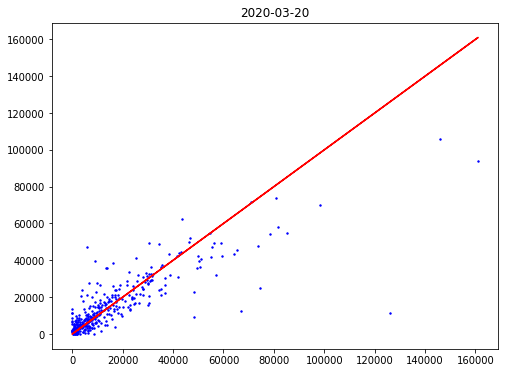

In [105]:
import importlib
importlib.reload(sys.modules['pfe_sym'])
from pfe_sym import nnls
import math
cur_date_time = datetime.datetime.combine(start_date, time_basis)
# end_date = datetime.date(2019, 3, 25)
end_date_time = datetime.datetime.combine(end_date, time_basis)

all_r = []
all_P = []
all_x_o = np.array([])
all_alr = []
all_A = None

q_dict = {}
q_dict_2d = {}

# print('Alr_sym: ',Alr_sym.shape)
# tmp_a = np.zeros((Alr_sym.shape[0], num_origin * N), int)
# Alr_sym = np.concatenate((Alr_sym,tmp_a),axis=1)

N = int(60 / time_interval_min * 24)
M = len(OD_paths)

nrow = math.ceil(len(date_need_to_finish)/5);
ncol = 5

# fig, axs = plt.subplots(2,3,figsize=(30,20))

# print(axs)
i = 0
observe_index_N = np.load("observe_index_N.npy")

while(cur_date_time <= end_date_time):
    print(cur_date_time)
    no = cur_date_time.weekday()
    if (no > flag_weekday1) & (no < flag_weekday2):
        single_date = cur_date_time.date()
        date_str = single_date.strftime("%Y-%m-%d")
        
        x_o = np.load(os.path.join('X_vector', date_str + ".npy"))
#         print('X_vector', date_str," ",x)
        
        print('x: ',len(x_o))
        r = joblib.load(os.path.join("R_matrix", date_str + ".pickle")).tocsr()
#         r = joblib.load(os.path.join("R_matrix", date_str + ".pickle")).toarray()
        print('r: ', r.shape)
        print('r type: ', type(r))
        
        P = joblib.load(os.path.join("P_matrix", date_str+".pickle")).tocsr()
#         P = joblib.load(os.path.join("P_matrix", date_str+".pickle")).toarray()
        print('P: ',P.shape)
        
        RP = np.array(r.dot(P).toarray())[observe_index_N == 1,:]
#         RP = (r.dot(P)).toarray()
#         print('RP: ', RP.shape)
#         print('RP: ', type(RP))
#         print('observe_index_N: ', observe_index_N.shape)
        
        ###############################################
        ################Read in file###################
        ###############################################
        Alr_sym = np.load(os.path.join('Constraints', "Alr_sym.npy"))
        Alr_arterial = np.load(os.path.join('Constraints', "Alr_arterial.npy"))
        b_sym = np.load(os.path.join('Constraints', "b_sym.npy"))
        b_arterial = np.load(os.path.join('Constraints', "b_arterial.npy"))
        ###############################################
        ###############################################
        
        ###############################################
        ################Constraints####################
        ###############################################
        x2,y2 = Alr_arterial.shape
        A = np.concatenate((RP, Alr_sym*10), axis=0)
        x1,y1 = A.shape
        A = np.concatenate((A, np.zeros((x1,y2-y1))), axis=1)
        A = np.concatenate((A, Alr_arterial), axis=0)
        print('x1,y1, ', x1,y1)
        print('x2,y2, ', x2,y2)
        print('x_o, ', x_o.shape)
        print('b_sym, ', b_sym.shape)
#         print('b_arterial, ', b_arterial.shape)
        b = np.concatenate((x_o, b_sym), axis=0)
        b = np.concatenate((b, b_arterial.reshape(-1)), axis = 0)
        b_max = np.max(b)
        q_init = np.concatenate((q_sym, np.random.rand(y2-y1)), axis=0)
        print('q shape, ', q_init)
#         b = b/b_max
        ###############################################
        ###############################################
        N = int(60 / time_interval_min * 24)-1
        M = len(OD_paths)
        
        print('A',np.max(A))
        print('b',np.max(b))
#         (q_est, r_norm) = sc.optimize.nnls(A, b)
        print('A shape', A.shape)
        (q_est, r_norm) = nnls(A,b,q_init,1000,500,5,True) #1e10or20: 2000, 1000, 5; best: 1000, 500, 5
#         q_est = q_est * b_max
        print("solve q.")
        print('error, ', r_norm)
        print('q_est, ', q_est.sum())
        
        np.save(os.path.join('Q_vector', 'q_vector_sym_10.npy'), q_est[:y1])
        
#         q_est = q_est[:y1]
        q_est_2d = q_est[:y1].reshape(N,M)
        
#         q_dict[cur_date_time] = q_est
#         q_dict_2d[cur_date_time] = q_est_2d[:-1,:]
        
#         print('q_dict_2d,', q_dict_2d[cur_date_time].shape)
        
        x_est =  RP.dot(q_est[:y1])
        
        error1 = np.sum(np.absolute(x_o - x_est))
        error2 = np.sum(np.absolute(Alr_sym.dot(q_est[:y1])))
        error3 = np.sum(np.absolute(Alr_arterial.dot(q_est)))
        print('error1, ',error1,'error2, ',error2,'error3, ',error3)
        axis_y = i%3
        axis_x = int(i/3)
        
        plt.scatter(x_o, x_est, c = 'b', s=2)
        plt.plot(x_o, x_o, 'r')

        plt.title(date_str)
        plt.savefig(date_str+'.png')
    
        date_need_to_finish.append(single_date)
        i += 1
    cur_date_time = cur_date_time + delta_date
fig.show()


-1.1102230246251565e-16

In [ ]:
import numpy as np

N = 100
# b = np.random.random(-2000,2000,size=(N,N))
x = np.random.rand(N,M)
print(x)
x = x.T + x/2



In [21]:
print(np.random.rand(1,N))

[[0.45409689 0.06715739 0.77499994]]


In [ ]:
x_o = np.load(os.path.join('X_vector', date_str + ".npy"))

In [112]:
Alr_sym.dot(q_est)

array([ 0.00000000e+00,  0.00000000e+00,  1.94461097e-25,  1.23659004e-25,
       -2.67743828e-26,  3.77135418e-26,  3.79486567e-26,  8.22809002e-26,
        1.85051684e-25,  8.97399938e-26,  1.35047678e-26, -2.96896037e-26,
       -8.17482475e-26, -5.20615085e-26,  1.24828058e-25, -5.45696821e-27,
        2.59696143e-26,  2.56447018e-25,  3.04375842e-26,  1.16462440e-25,
       -3.89567517e-26, -3.72740769e-26, -9.16163840e-26, -2.83605287e-26,
       -1.42304927e-25, -1.73243693e-25,  1.16725894e-25,  0.00000000e+00,
        0.00000000e+00,  2.99411551e-25, -1.82791132e-25, -2.24864403e-25,
       -2.17588403e-25, -1.15724914e-25,  3.62738871e-25, -2.22826202e-25,
       -1.91903382e-25, -1.27259745e-25, -1.32095840e-25, -1.75924094e-25,
        3.03619971e-25, -1.91947010e-25, -1.78545179e-25, -2.60206079e-25,
       -2.19350573e-25, -8.31765474e-26, -1.86429272e-25, -1.86429166e-25,
       -1.30283771e-25, -1.26193861e-25, -9.39025132e-26, -9.49859664e-26,
        2.92707779e-25,  

In [ ]:
## plot the graph

for date, q_est_2d in q_dict_2d.items():
    aggregate_flow = np.sum(q_est_2d,1)
    x=np.arange(0, 22, time_interval_min/60)
    plt.plot(x,aggregate_flow, label = date.strftime("%Y-%m-%d"))
    plt.legend()
plt.show()


In [ ]:
print(q_est_2d.shape)

In [ ]:
## path plot
fig = plt.figure(figsize=(20, 5))

for date, q_est_2d in q_dict_2d.items():
    cols_id = random.sample(range(0, q_est_2d.shape[1]-1), 10)
    tmp = q_est_2d[:, cols_id]
    for i in range(tmp.shape[1]):
        x=np.arange(0, 22, time_interval_min/60)
        
        graph = fig.add_subplot(2, 5, i+1)
        graph.plot(x,tmp[:,i])
        graph.set_xticks(x, minor=False)
        graph.set_title('path flow')


In [ ]:
## calculate mean and variance
res = sum(q_dict_2d.values()) / len(q_dict_2d)
# print(res)
x=np.arange(0, 22, time_interval_min/60)
plt.plot(x, np.sum(res,axis = 1),label = "mean")
plt.legend()

In [ ]:
a = np.array(list(q_dict_2d.values()))

std = np.std(a, axis = 0)
print(std.shape)
plt.plot(x,np.max(std,axis = 1),label = "std")
plt.legend()

In [ ]:
for date, q_est_2d in q_dict_2d.items():
    aggregate_flow = np.sum(q_est_2d,1)
    x=np.arange(0, 23, time_interval_min/60)
    plt.plot(x,aggregate_flow)
    
plt.show()

In [ ]:
import importlib
# importlib.reload(sys.modules['pfe'])
from pfe import nnls
from fnnls import fnnls
start_time = datetime.datetime.now()
# (q_est, r_norm) = nnls(all_A, all_x_o, 500, 100, 10)
# q_est = q_est[:num_path]
(q_est, r_norm) = sc.optimize.nnls(all_A, all_x_o)
# (q_est, r_norm) = fnnls(all_A, all_x_o)
# x_est =  all_A.dot(q_est)
t_ = (datetime.datetime.now() - start_time)
print("nnls: ",t_)

In [ ]:
#print(q_est)
N = int(60 / time_interval_min * 24)
M = len(OD_paths)
np.save(os.path.join('Q_vector', 'q_vector_withslack'), q_est)

q_est = q_est[:N*M]
q_est_2d = q_est.reshape(N,M)
np.set_printoptions(threshold=sys.maxsize)
np.save(os.path.join('Q_vector', 'q_vector_noslack'), q_est)
np.save(os.path.join('Q_vector', 'q_vector_2d'), q_est_2d)
np.savetxt( './Q_vector/q_est_2d.txt', q_est_2d, delimiter = ',',fmt='%s')
#print(q_est_2d[:,7])

# x_est =  all_A.dot(q_est)
# plt.plot(all_x_o, x_est, 'o')
# plt.plot(all_x_o, all_x_o, 'r')
#print("x_est: ", x_est)
# plt.show()

# x=np.arange(0, 24, time_interval_min/60)
# graph = fig.add_subplot(nrows, ncols, 3)
# graph.plot(x,link_flow)
# graph.set_xticks(x, minor=False)
# graph.set_title('true one link flow')
# plotname = 'link_flow_'+start_date.strftime("%m_%d_%Y")+'_'+str(time_interval_min)+'.png'
# graph.figure.savefig(new_file + "/" + "plot/" + plotname)

# plt.savefig('books_read.png')

In [ ]:
#####Set write path####
new_file = None
if new_file==None:
#     new_file = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")+'__'+start_date.strftime("%m_%d_%Y")+'_'+str(time_interval_min)+'_'+str(num_path)
    if flag_weekday == 1:
        new_file = start_date.strftime("%m_%d_%Y")+'_' + end_date.strftime("%m_%d_%Y")+'_Weekday_'+str(time_interval_min)+'_'+str(num_path)
    else:
        new_file = start_date.strftime("%m_%d_%Y")+'_' + end_date.strftime("%m_%d_%Y")+'_Weekend_'+str(time_interval_min)+'_'+str(num_path)
    
    if (os.path.exists(new_file) == False):
        os.mkdir(new_file)
        os.mkdir(os.path.join(new_file,"plot"))
        os.mkdir(os.path.join(new_file,"result"))
        os.mkdir(os.path.join(new_file,'Q_vector'))
        os.mkdir(os.path.join(new_file,'Path_list'))

####### Plot true value and estimate value ########
x_est =  all_A.dot(q_est)
x1 = x_est[np.where(all_x_o < 200)]
x_o1 = all_x_o[np.where(all_x_o < 200)]
# plt.scatter(all_x_o, x_est, c = 'b', s=2)
# plt.plot(all_x_o, all_x_o, 'r')

plt.scatter(x_o1, x1, c = 'b', s=2)
plt.plot(x_o1, x_o1, 'r')

#print("x_est: ", x_est)
# plt.show()
#print(q_est)
# N = int(60 / time_interval_min * 24)
# M = len(OD_paths)
# q_est_2d = q_est.reshape(N,M)
# np.set_printoptions(threshold=sys.maxsize)
plotname = 'true_estimate_value_'+start_date.strftime("%m_%d_%Y")+'_'+str(time_interval_min)+'.png'
plt.savefig(new_file + "/" + "plot/" + plotname)
        
####### Graphs #######
nrows = 1
ncols = 3
fig = plt.figure(figsize=(20, 5))

#####Plot aggregate flow of the day####
print(q_est_2d.shape)
print(np.sum(q_est_2d,1))
aggregate_flow = np.sum(q_est_2d,1)
x=np.arange(0, 24, time_interval_min/60)
graph = fig.add_subplot(nrows, ncols, 1)
graph.plot(x,aggregate_flow)
graph.set_xticks(x, minor=False)
graph.set_title('estimate aggregate flow')
plotname = 'aggregate_input_flow_'+start_date.strftime("%m_%d_%Y")+'_'+str(time_interval_min)+'.png'
graph.figure.savefig(new_file + "/" + "plot/" + plotname)

#####Plot one link flow of the day####
#x_est_2d = np.array(x_est).reshape((len(date_need_to_finish),N,num_link))
# x_est_2d = np.array(x_est).reshape((-1,N))
# link_flow = x_est_2d[47,:]
x_est_2d = np.array(x_est).reshape((N,-1))
link_flow = x_est_2d[:,1]
# print(x_est_2d.shape)
# print(np.sum(x_est_2d,1))
# link_flow = x_est_2d[1,:]
x=np.arange(0, 24, time_interval_min/60)
graph = fig.add_subplot(nrows, ncols, 2)
graph.plot(x,link_flow)
graph.set_xticks(x, minor=False)
graph.set_title('estimate one link flow')
plotname = 'link_flow_'+start_date.strftime("%m_%d_%Y")+'_'+str(time_interval_min)+'.png'
graph.figure.savefig(new_file + "/" + "plot/" + plotname)

#####Plot one link flow of the day####
# x_o_2d = np.array(all_x_o).reshape((-1,N))
# link_flow = x_o_2d[47,:]
x_o_2d = np.array(all_x_o).reshape((N,-1))
link_flow = x_o_2d[:,1]

x=np.arange(0, 24, time_interval_min/60)
graph = fig.add_subplot(nrows, ncols, 3)
graph.plot(x,link_flow)
graph.set_xticks(x, minor=False)
graph.set_title('true one link flow')
plotname = 'link_flow_'+start_date.strftime("%m_%d_%Y")+'_'+str(time_interval_min)+'.png'
graph.figure.savefig(new_file + "/" + "plot/" + plotname)

####Record nonzero result and q pickle####
f = open(new_file + "/" + "result/" + "nnls_estimation.txt", "a")
perc_q1 = 100 * (float(q_est[q_est >= 0].shape[0]) / float(q_est.shape[0]))
perc_q2 = 100 * (float(q_est[q_est == 0].shape[0]) / float(q_est.shape[0]))
f.write("Date: " + start_date.strftime("%m_%d_%Y") + "\n")
f.write("time_interval: %.2f \n" % time_interval_min)
f.write("number of path: %.2f \n" % num_path)
f.write("R_norm in the nnls: %.2f \n" % r_norm)
f.write("Percentage of non-negative values in the q_est: %.2f \n" % perc_q1)
f.write("Percentage of zero values in the q_est: %.2f \n" % perc_q2)
f.close()

#####Save data result####
# Save OD flow 
pickle.dump((q_est, r_norm), open(os.path.join('Q_vector', date_str + '.pickle'), 'wb'))
np.savetxt( new_file + '/Q_vector/' +'q_est_'+start_date.strftime("%m_%d_%Y")+'_'+\
           str(time_interval_min)+'.txt', q_est_2d, delimiter = ',')
# Save Path list
shortest_path_list = np.array(shortest_path_list)
np.savetxt( new_file + '/Path_list/' +'path_'+start_date.strftime("%m_%d_%Y")+'_'+\
           str(time_interval_min)+'.txt', shortest_path_list, delimiter = ',',fmt='%s')
# Save OD location


In [ ]:
new_file = None
if new_file==None:
#     new_file = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")+'__'+start_date.strftime("%m_%d_%Y")+'_'+str(time_interval_min)+'_'+str(num_path)
    if flag_weekday == 1:
        new_file = start_date.strftime("%m_%d_%Y")+'_' + end_date.strftime("%m_%d_%Y")+'_Weekday_'+str(time_interval_min)+'_'+str(num_path)
    else:
        new_file = start_date.strftime("%m_%d_%Y")+'_' + end_date.strftime("%m_%d_%Y")+'_Weekend_'+str(time_interval_min)+'_'+str(num_path)
    
    if (os.path.exists(new_file) == False):
        os.mkdir(new_file)
        os.mkdir(os.path.join(new_file,"plot"))
        os.mkdir(os.path.join(new_file,"result"))
        os.mkdir(os.path.join(new_file,'Q_vector'))
        os.mkdir(os.path.join(new_file,'Path_list'))
np.savetxt( new_file + '/Path_list/' +'path_'+start_date.strftime("%m_%d_%Y")+'_'+\
           str(time_interval_min)+'.txt', shortest_path_list, delimiter = ',',fmt='%s')

In [ ]:
print(shortest_path_list)

In [ ]:
np.savetxt( new_file + '/Path_list/' +'path_'+start_date.strftime("%m_%d_%Y")+'_'+\
           str(time_interval_min)+'.txt', OD_list_output, delimiter = ',',fmt='%s')

In [ ]:
origin_list_region = np.array([[17,28,-1,-1,-1,-1,-1],
                             [15,13,25,26,27,29,-1],
                             [2,3,9,20,37,12,22],
                             [19,30,31,32,33,34,-1],
                             [0,1,16,39,-1,-1,-1],
                             [38,24,4,5,-1,-1,-1],
                             [21,35,36,18,6,-1,-1],
                             [7,8,10,11,14,23,-1]])
result = np.where(origin_list_region == 15)
print(result[1])

In [ ]:
math.ceil(len(date_need_to_finish)/5)

In [ ]:
len(date_need_to_finish)